In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import polars as pl
import seaborn as sns

%reload_ext autoreload
%autoreload 2

In [2]:
import polars as pl

df_merchants = pl.read_csv("../datasets/merchants.csv").cast({i: pl.Categorical for i in ["merchant_id", "category", "country"]})
df_merchants = df_merchants.rename({i: f"{i}_merchant" for i in df_merchants.columns[1:]})

cat_columns = {i: pl.Categorical for i in ["user_id", "education", "sex", "primary_source_of_income", "country"]}
df_users = pl.read_csv("../datasets/users.csv", try_parse_dates=True).cast(cat_columns)
df_users = df_users.rename({i: f"{i}_user" for i in df_users.columns[1:]})

cat_columns = {i: pl.Categorical for i in ["user_id", "merchant_id", "channel", "currency", "device", "payment_method"]}
date_columns = {i: pl.Datetime for i in ["timestamp"]}
df_transactions = pl.read_ndjson("../datasets/transactions.json").cast(cat_columns | date_columns).unnest("location")

df_full = df_transactions.join(df_users, on="user_id", how="left").join(df_merchants, on="merchant_id", how="left").sort("timestamp")
# df_full

/tmp/ipykernel_27779/394467942.py:14: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df_full = df_transactions.join(df_users, on="user_id", how="left").join(df_merchants, on="merchant_id", how="left").sort("timestamp")


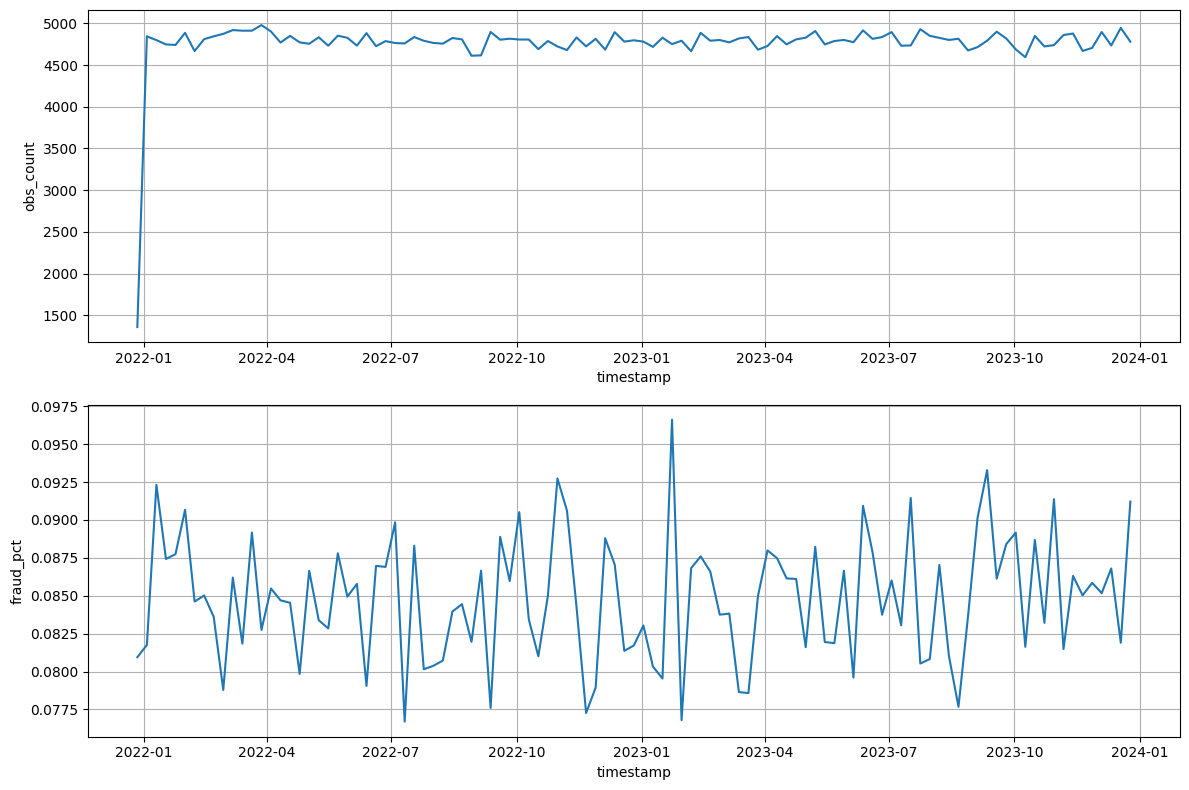

In [3]:
x = df_full.group_by_dynamic(
    index_column="timestamp",
    every="1w",
).agg(
    pl.len().alias("obs_count"),
    (pl.col("is_fraud").sum() / pl.col("is_fraud").len()).alias("fraud_pct"),
)


fig, ax = plt.subplots(2, 1, figsize=(12, 8))
[a.grid(True) for a in ax]
sns.lineplot(x=x["timestamp"], y=x["obs_count"], ax=ax[0])
sns.lineplot(x=x["timestamp"], y=x["fraud_pct"], ax=ax[1])
fig.tight_layout()

In [4]:
# around 20% for test
df_train = df_full.filter(pl.col("timestamp") < pl.datetime(2023, 9, 1))
df_test = df_full.filter(pl.col("timestamp") >= pl.datetime(2023, 9, 1))
# df_train

In [8]:
print(df_train.head(1))

shape: (1, 31)
┌────────────┬───────────┬─────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ transactio ┆ timestamp ┆ user_id ┆ merchant_ ┆ … ┆ number_of ┆ avg_trans ┆ account_a ┆ has_fraud │
│ n_id       ┆ ---       ┆ ---     ┆ id        ┆   ┆ _alerts_l ┆ action_am ┆ ge_months ┆ _history_ │
│ ---        ┆ datetime[ ┆ cat     ┆ ---       ┆   ┆ ast_6_mon ┆ ount_merc ┆ _merchant ┆ merchant  │
│ str        ┆ μs]       ┆         ┆ cat       ┆   ┆ ths…      ┆ han…      ┆ ---       ┆ ---       │
│            ┆           ┆         ┆           ┆   ┆ ---       ┆ ---       ┆ i64       ┆ i64       │
│            ┆           ┆         ┆           ┆   ┆ i64       ┆ f64       ┆           ┆           │
╞════════════╪═══════════╪═════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ TX497783   ┆ 2022-01-0 ┆ U04367  ┆ M0197     ┆ … ┆ 1         ┆ 85.26     ┆ 79        ┆ 1         │
│            ┆ 1         ┆         ┆           ┆   ┆           ┆           ┆

In [ ]:
time_features = [
    "year",
    "month",
    "day_of_month",
    "hour_of_day",
    "day_of_week",
    "day_of_year",
    "week_of_year",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "day_of_week_cos",
    "month_cos",
    "day_of_year_sin",
    "day_of_year_cos",
    "is_business_hours",
]
df_with_features = df_train.with_columns(
    [
        # standard date features
        pl.col("timestamp").dt.year().alias("year"),
        pl.col("timestamp").dt.month().alias("month"),
        pl.col("timestamp").dt.day().alias("day_of_month"),
        pl.col("timestamp").dt.hour().alias("hour_of_day"),
        pl.col("timestamp").dt.weekday().alias("day_of_week"),
        pl.col("timestamp").dt.ordinal_day().alias("day_of_year"),
        pl.col("timestamp").dt.week().alias("week_of_year"),
        # weekend
        pl.col("timestamp").dt.weekday().is_in([6, 7]).alias("is_weekend"),
        # cyclical features
        (pl.col("timestamp").dt.hour() * (2 * np.pi / 24)).sin().alias("hour_sin"),
        (pl.col("timestamp").dt.hour() * (2 * np.pi / 24)).cos().alias("hour_cos"),
        ((pl.col("timestamp").dt.weekday() - 1) * (2 * np.pi / 7)).cos().alias("day_of_week_cos"),
        ((pl.col("timestamp").dt.month() - 1) * (2 * np.pi / 12)).cos().alias("month_cos"),
        ((pl.col("timestamp").dt.ordinal_day() - 1) * (2 * np.pi / 365.25)).sin().alias("day_of_year_sin"),
        ((pl.col("timestamp").dt.ordinal_day() - 1) * (2 * np.pi / 365.25)).cos().alias("day_of_year_cos"),
        # business hours
        (
            (
                (pl.col("timestamp").dt.weekday().is_in(list(range(1, 6))))
                & (pl.col("timestamp").dt.hour() >= 9)
                & (pl.col("timestamp").dt.hour() < 17)
            ).alias("is_business_hours")
        ),
    ]
)
df_with_features

transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,lat,long,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud,age_user,sex_user,education_user,primary_source_of_income_user,sum_of_monthly_installments_user,sum_of_monthly_expenses_user,country_user,signup_date_user,risk_score_user,category_merchant,country_merchant,trust_score_merchant,number_of_alerts_last_6_months_merchant,avg_transaction_amount_merchant,account_age_months_merchant,has_fraud_history_merchant,year,month,day_of_month,hour_of_day,day_of_week,day_of_year,week_of_year,is_weekend,hour_sin,hour_cos,day_of_week_cos,month_cos,day_of_year_sin,day_of_year_cos,is_business_hours
str,datetime[μs],cat,cat,f64,cat,cat,cat,f64,f64,cat,i64,i64,i64,i64,i64,cat,cat,cat,f64,f64,cat,date,f64,cat,cat,f64,i64,f64,i64,i64,i32,i8,i8,i8,i8,i16,i8,bool,f64,f64,f64,f64,f64,f64,bool
"""TX497783""",2022-01-01 00:06:00,"""U04367""","""M0197""",41.78,"""in-store""","""EUR""","""Android""",53.688447,36.092441,"""mobile_payment""",1,222,0,0,59,"""Female""","""PhD""","""Student Aid""",427.75,997.08,"""Netherlands""",2022-02-02,0.696529,"""electronics""","""Germany""",0.867635,1,85.26,79,1,2022,1,1,0,6,1,52,true,0.0,1.0,-0.222521,1.0,0.0,1.0,false
"""TX087684""",2022-01-01 00:12:00,"""U07964""","""M0056""",77.36,"""online""","""EUR""","""Android""",68.951114,13.106446,"""debit_card""",1,308,0,0,22,"""Male""","""High School""","""Unemployment""",125.4,402.97,"""Finland""",2023-11-01,0.397698,"""travel""","""Belgium""",0.756445,3,24.93,69,0,2022,1,1,0,6,1,52,true,0.0,1.0,-0.222521,1.0,0.0,1.0,false
"""TX466651""",2022-01-01 00:12:00,"""U02226""","""M0496""",160.69,"""in-store""","""EUR""","""Android""",35.875333,-1.288573,"""bank_transfer""",1,874,1,0,22,"""Other""","""PhD""","""Retirement""",53.3,805.98,"""Denmark""",2020-06-27,0.619942,"""clothing""","""Sweden""",0.887738,2,94.39,79,1,2022,1,1,0,6,1,52,true,0.0,1.0,-0.222521,1.0,0.0,1.0,false
"""TX005076""",2022-01-01 00:13:00,"""U04685""","""M0484""",45.19,"""in-store""","""EUR""","""Web""",60.437928,38.060866,"""debit_card""",1,1200,1,0,40,"""Other""","""Bachelor""","""Student Aid""",554.37,615.45,"""Netherlands""",2020-08-16,0.330483,"""travel""","""Spain""",0.596116,5,23.05,31,1,2022,1,1,0,6,1,52,true,0.0,1.0,-0.222521,1.0,0.0,1.0,false
"""TX429480""",2022-01-01 00:14:00,"""U13341""","""M0960""",10.76,"""online""","""EUR""","""Web""",40.255723,14.582348,"""bank_transfer""",1,1034,1,0,72,"""Other""","""Master""","""Unemployment""",109.87,496.5,"""Poland""",2022-08-20,0.393215,"""education""","""Portugal""",0.857549,0,82.35,82,1,2022,1,1,0,6,1,52,true,0.0,1.0,-0.222521,1.0,0.0,1.0,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""TX422934""",2023-08-31 23:44:00,"""U02973""","""M0920""",42.71,"""mobile""","""EUR""","""Web""",54.501074,19.70325,"""bank_transfer""",1,250,1,0,19,"""Other""","""PhD""","""Student Aid""",166.24,1690.22,"""Spain""",2023-03-24,0.740161,"""restaurants""","""Italy""",0.335964,3,67.81,100,0,2023,8,31,23,4,243,35,false,-0.258819,0.965926,-0.900969,-0.866025,-0.852837,-0.522178,false
"""TX439715""",2023-08-31 23:55:00,"""U11810""","""M0651""",48.75,"""in-store""","""EUR""","""Android""",62.403279,33.434437,"""credit_card""",0,1129,1,0,33,"""Other""","""High School""","""Business""",494.74,2958.68,"""Denmark""",2022-01-14,0.43757,"""grocery""","""Denmark""",0.940626,2,117.2,80,1,2023,8,31,23,4,243,35,false,-0.258819,0.965926,-0.900969,-0.866025,-0.852837,-0.522178,false
"""TX254420""",2023-08-31 23:56:00,"""U09074""","""M0177""",11.23,"""in-store""","""EUR""","""iOS""",63.62315,-5.486134,"""credit_card""",1,920,0,0,37,"""Male""","""High School""","""Unemployment""",140.93,1171.95,"""Germany""",2024-11-21,0.489007,"""electronics""","""Spain""",0.297455,1,116.74,31,0,2023,8,31,23,4,243,35,false,-0.258819,0.965926,-0.900969,-0.866025,-0.852837,-0.522178,false


<Axes: ylabel='Count'>

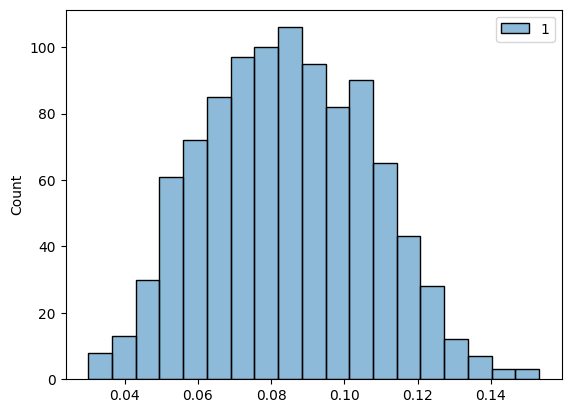

In [5]:
x = df_train.group_by(["merchant_id"]).agg(pl.col("is_fraud").sum() / pl.col("is_fraud").len()).sort("is_fraud")
sns.histplot(x)


<Axes: ylabel='Count'>

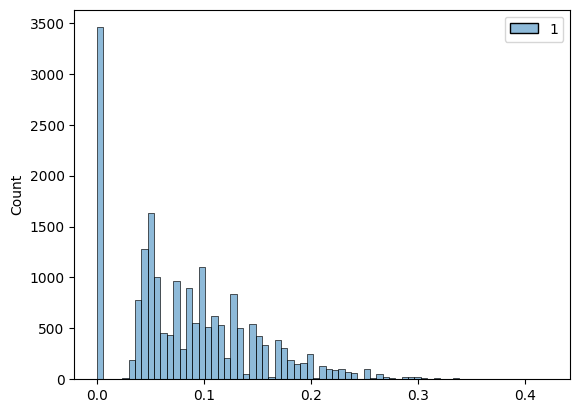

In [6]:
x = df_train.group_by(["user_id"]).agg(pl.col("is_fraud").sum() / pl.col("is_fraud").len()).sort("is_fraud")
sns.histplot(x)

In [7]:
target = "is_fraud"
numeric_features = [
    "amount",
    "session_length_seconds",
    "age_user",
    "sum_of_monthly_installments_user",
    "sum_of_monthly_expenses_user",
    "risk_score_user",
    "trust_score_merchant",
    "number_of_alerts_last_6_months_merchant",
    "avg_transaction_amount_merchant",
    "account_age_months_merchant",
    "has_fraud_history_merchant",
]
categorical_features = [
    "user_id",
    "merchant_id",
    "channel",
    "currency",
    "device",
    "payment_method",
    "is_international",
    "sex_user",
    "education_user",
    "primary_source_of_income_user",
    "country_user",
    "category_merchant",
    "country_merchant",
]
features = numeric_features + categorical_features
columns = features + [target]

df_train = df_full.filter(pl.col("timestamp") < pl.datetime(2023, 9, 1))
df_test = df_full.filter(pl.col("timestamp") >= pl.datetime(2023, 9, 1))

df_train, df_test = df_train[columns], df_test[columns]

In [ ]:
df_train = df_full.filter(pl.col("timestamp") < pl.datetime(2023, 9, 1))
df_test = df_full.filter(pl.col("timestamp") >= pl.datetime(2023, 9, 1))

time_features = ["amount_quarter_mean", "amount_quarter_max"]


quarterly_statistics = (
    df_train.group_by_dynamic(index_column="timestamp", group_by=["user_id"], every="1q")
    .agg(
        pl.col("amount").mean().alias("amount_quarter_mean"),
        pl.col("amount").max().alias("amount_quarter_max"),
    )
    .sort("timestamp")
)

df_test.join_asof(quarterly_statistics, on="timestamp", by="user_id")

In [ ]:
df_test

In [ ]:
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit


k = TimeSeriesSplit()

for i in k.split(df_test["user_id"], df_test["is_fraud"]):
    print(i)

(array([    0,     1,     2, ..., 13875, 13876, 13877], shape=(13878,)), array([13878, 13879, 13880, ..., 27751, 27752, 27753], shape=(13876,)))
(array([    0,     1,     2, ..., 27751, 27752, 27753], shape=(27754,)), array([27754, 27755, 27756, ..., 41627, 41628, 41629], shape=(13876,)))
(array([    0,     1,     2, ..., 41627, 41628, 41629], shape=(41630,)), array([41630, 41631, 41632, ..., 55503, 55504, 55505], shape=(13876,)))
(array([    0,     1,     2, ..., 55503, 55504, 55505], shape=(55506,)), array([55506, 55507, 55508, ..., 69379, 69380, 69381], shape=(13876,)))
(array([    0,     1,     2, ..., 69379, 69380, 69381], shape=(69382,)), array([69382, 69383, 69384, ..., 83255, 83256, 83257], shape=(13876,)))


In [ ]:
from sklearn.compose import make_column_transformer
import lightgbm
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score


transformer = make_column_transformer(
    # (OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan), categorical_features),
    ("passthrough", features),
    remainder="passthrough",
).set_output(transform="polars")

X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]

X_train = transformer.fit_transform(X_train).to_pandas()
X_test = transformer.transform(X_test).to_pandas()

In [ ]:
# categorical features names after passing columntransformer
categorical_features_trns = [i for i in X_train.columns if i.split("__")[1] in categorical_features]
model = lightgbm.LGBMClassifier(class_weight="balanced", random_state=13)
model.fit(X_train, y_train, eval_metric="auc", categorical_feature=categorical_features_trns)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 35208, number of negative: 381534
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22465
[LightGBM] [Info] Number of data points in the train set: 416742, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [ ]:
y_hat = model.predict(X_test)

{
    "accuracy": accuracy_score(y_test, y_hat),
    "auc": roc_auc_score(y_test, y_hat),
    "f1_score": f1_score(y_test, y_hat),
}

{'accuracy': 0.6111364673664993,
 'auc': np.float64(0.530007304442293),
 'f1_score': 0.16120006217938754}